# Importing libraries

In [1]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import copy

# Creating custom functions

In [2]:
# Working with the chinook.db database. 

chinook = '/home/yeachan153/Desktop/BDS/Python/Datasets/chinook.db'

# Executes the query and returns a pandas dataframe
def run_query(query):
    with sqlite3.connect(chinook) as conn:
        return pd.read_sql_query(query, conn)

# Used to create views - enter query as command
# Can drop too using 'DROP VIEW view_name;' 
def run_command(command):
    with sqlite3.connect(chinook) as conn:
        conn.isolation_level = None 
        conn.execute(command)

# Returns a pd.df Type column shows whether it's a table or a view
def show_tables():
    query = '''
    SELECT name, type
    FROM sqlite_master
    WHERE type IN ("table", "view");
    '''
    return run_query(query)

# Showing the structure of the tables

In [3]:
print(show_tables())

              name   type
0            album  table
1           artist  table
2         customer  table
3         employee  table
4            genre  table
5          invoice  table
6     invoice_line  table
7       media_type  table
8         playlist  table
9   playlist_track  table
10           track  table
11          subset   view
12    customer_USA   view


## Image showing how the tables are linked in the database

![title](https://s3.amazonaws.com/dq-content/190/chinook-schema.svg)

# Answering Questions

### Returning summary data by country - total number of customers, total value of sales, average order value, average value of sales per customer (ordered by total revenue).

In [4]:
query = '''
WITH 
    country_condense AS
        (
        SELECT 
            Country Country1,
            CASE
                WHEN COUNT(Country) <= 1
                    THEN "Other"
                ELSE "Country"
            END
            AS "Reclassified"
        FROM customer
        GROUP BY country
        ),
    ungrouped AS
        (
        SELECT 
            cc.Reclassified,
            COUNT(i.invoice_id) "Total number of Sales",
            COUNT(DISTINCT(i.customer_id)) "Unique Customer Total",
            SUM(i.total) "Value of Sales",
            AVG(i.total) "Average Order Value",
            SUM(i.total)/COUNT(DISTINCT(i.customer_id)) "Unique Customer Lifetime Spend"
        FROM invoice i
        LEFT JOIN customer c ON c.customer_id = i.customer_id
        INNER JOIN country_condense cc ON cc.Country1 = c.Country
        GROUP BY Country
        ),
    other AS
        (
        SELECT * 
        FROM ungrouped
        WHERE Reclassified = 'Other'
        ),
    other2 AS
        (
        SELECT 
            Reclassified,
            SUM("Total number of Sales") "Total number of Sales",
            SUM("Unique Customer Total") "Unique Customer Total",
            SUM("Value of Sales") "Value of Sales",
            AVG("Average Order Value") "Average Order Value",
            AVG("Unique Customer Lifetime Spend") "Unique Customer Lifetime Spend"
        FROM other
        GROUP BY Reclassified
        ),
    ungrouped2 AS
        (
        SELECT *
        FROM ungrouped
        WHERE Reclassified != "Other"
        ),
    unsorted AS
        (
        SELECT * 
        FROM ungrouped2
        UNION
        SELECT * FROM other2
        ORDER BY "Value of Sales" DESC
        )

SELECT
    Reclassified Country,
    "Total number of Sales",
    "Unique Customer Total",
    "Value of Sales",
    ROUND("Average Order Value",2) "Average Order Value",
    ROUND("Unique Customer Lifetime Spend",2) "Unique Customer Lifetime Spend"
FROM 
    (
     SELECT 
         un.*,
         CASE
             WHEN un.Reclassified = "Other" THEN 1
             ELSE 0
         END sort_val
     FROM unsorted un
    )
ORDER BY sort_val ASC

'''
df = run_query(query)
df

,Country,Total number of Sales,Unique Customer Total,Value of Sales,Average Order Value,Unique Customer Lifetime Spend
0,USA,131,13,1040.49,7.94,80.04
1,Canada,76,8,535.59,7.05,66.95
2,Brazil,61,5,427.68,7.01,85.54
3,France,50,5,389.07,7.78,77.81
4,Germany,41,4,334.62,8.16,83.66
5,Czech Republic,30,2,273.24,9.11,136.62
6,United Kingdom,28,3,245.52,8.77,81.84
7,Portugal,29,2,185.13,6.38,92.57
8,India,21,2,183.15,8.72,91.57
9,Other,147,15,1094.94,7.45,73.00


For next time: a more efficient way would be to create a 'with' with the values in the Country column pre-replaced with another column that contains the country or other

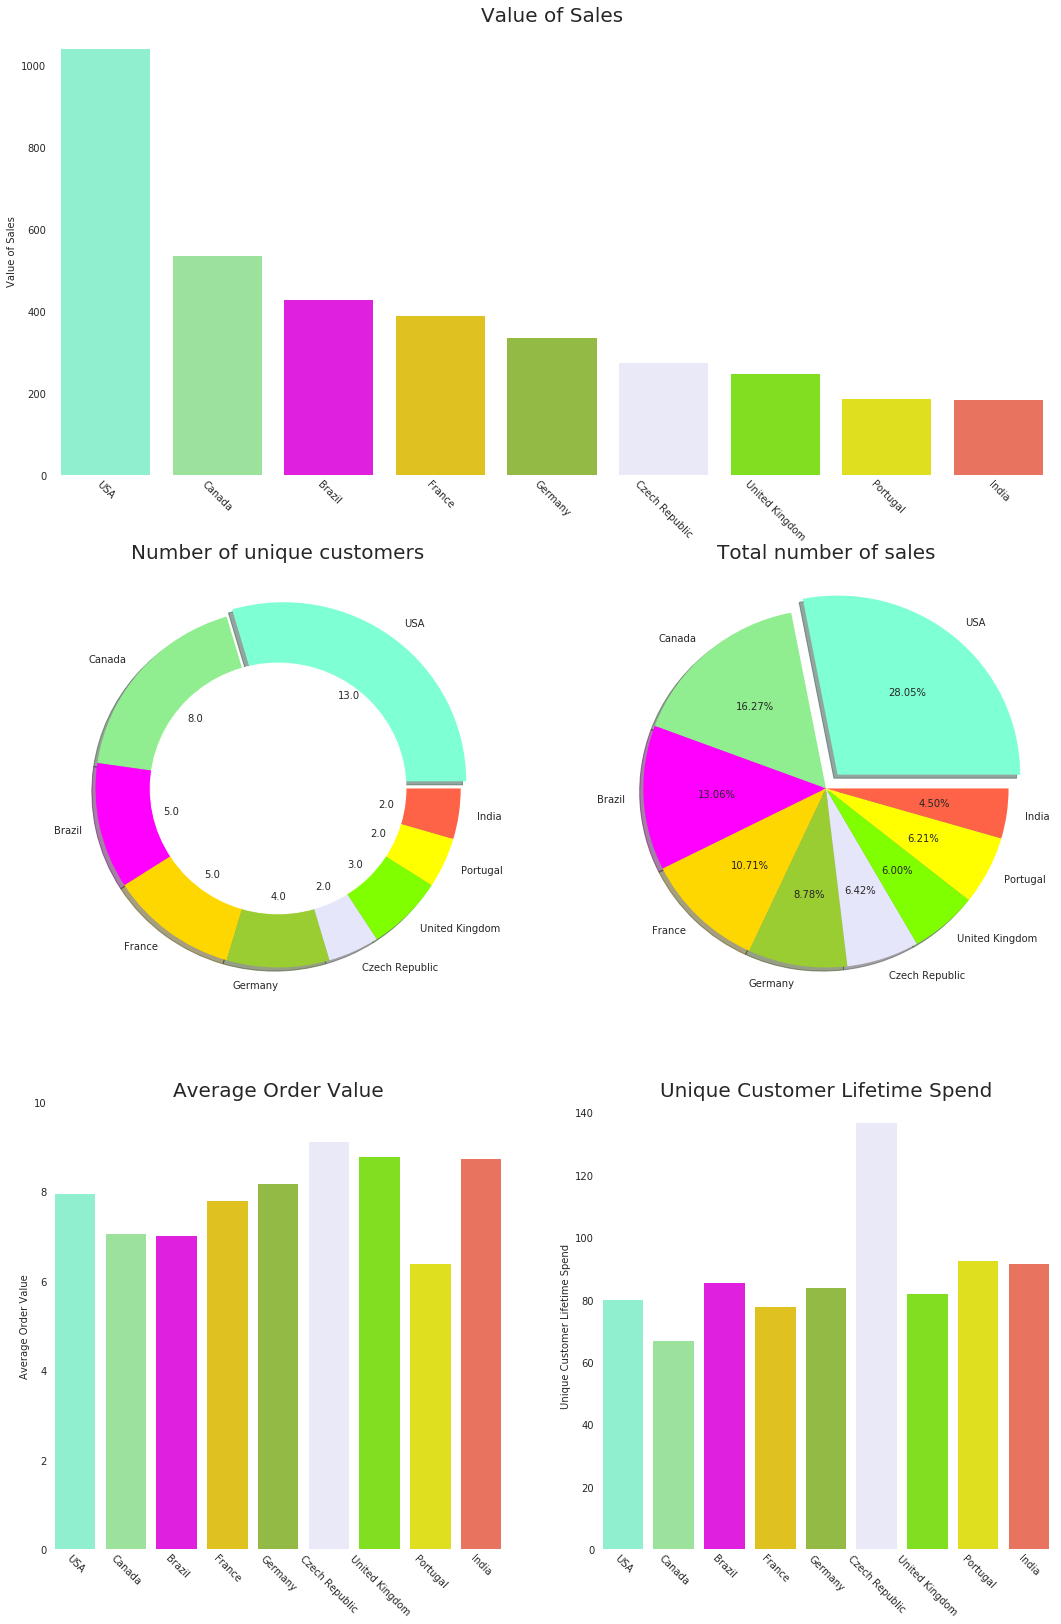

In [21]:
df = df[:9]
std_color = ["aquamarine", "lightgreen","fuchsia", "gold","yellowgreen", "lavender","chartreuse", "yellow","tomato"]
countries = df['Country'].tolist()

# Value of Sales
fig = plt.figure(figsize = (18,28))
plt.subplot2grid((3,2),(0,0), colspan=2)
ax = sns.barplot(y = 'Value of Sales', x = 'Country', data = df, palette = std_color)
plt.xticks(rotation = -45)
sns.set_style('white')
spines = ['right', 'left', 'bottom', 'top']
for each in spines:
    ax.spines[each].set_visible(False)
ax.set_title('Value of Sales', fontsize = 20)
ax.set_xlabel('')

# Unique Customers
def valuepct(value):
    val = value/100 * np.sum(df['Unique Customer Total'])
    return round(val,0)
plt.subplot2grid((3,2),(1,0))
plt.pie(df['Unique Customer Total'], explode = (0.05,0,0,0,0,0,0,0,0), colors = std_color,
       labels = countries, autopct=valuepct,shadow = True)
plt.title('Number of unique customers', fontsize = 20)
circle=plt.Circle((0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(circle)

# Total number of sales
plt.subplot2grid((3,2),(1,1))
plt.pie(df['Total number of Sales'], explode = (0.1,0,0,0,0,0,0,0,0), colors = std_color,
       labels = countries, autopct='%1.2f%%',shadow = True)
plt.title('Total number of sales', fontsize = 20)

cols = ['Average Order Value', 'Unique Customer Lifetime Spend']

for idx, each_col in enumerate(cols):
    plt.subplot2grid((3,2),(2,0 + idx))
    ax = sns.barplot(y = each_col, x = 'Country', data = df, palette = std_color)
    plt.xticks(rotation = -45)
    sns.set_style('white')
    spines = ['right', 'left', 'bottom', 'top']
    for each in spines:
        ax.spines[each].set_visible(False)
    ax.set_title(each_col, fontsize = 20)
    if idx == 0:
        ax.set_ylim(0,10)
    ax.set_xlabel('')

**Summary**

The main market appears to be in 4 countries. These four nations makes up for 68% of the total sales:
- USA
- Canada
- Brazil
- France

Future marketing could focus on:
- Germany
- Czech Republic
- UK
- Portugal
- India

It's hard to say more about which countries to recommend specifically at this point because there are such few unique customers per country. 

### 4 new artists have produced albums, and we must choose which 3 albums to advertise based on their genre. The adverts will only be shown to customers from the USA. 

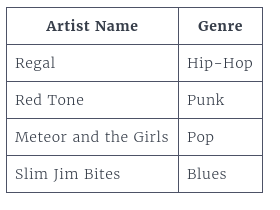

In [375]:
Image(filename='/home/yeachan153/Desktop/BDS/Python/SQL/Artist.png') 

In [25]:
# First create a View of customers from the USA
query = '''
CREATE VIEW customer_USA AS
    SELECT *
    FROM customer
    WHERE country = "USA";
'''
run_command(query)

In [26]:
query = '''
WITH
    subset AS
        (
        SELECT 
            g.name Genre,
            t.name Track
        FROM invoice i
        INNER JOIN customer_USA cu ON cu.customer_id = i.customer_id
        LEFT JOIN invoice_line il ON il.invoice_id = i.invoice_id
        LEFT JOIN track t ON il.track_id = t.track_id
        LEFT JOIN genre g ON g.genre_id = t.genre_id
        ),
    subset2 AS 
        (
        SELECT
            Genre,
            COUNT(TRACK) "Number of Tracks"
        FROM subset
        GROUP BY Genre
    )

SELECT 
    Genre,
    "Number of Tracks",
    CAST("Number of Tracks" as FLOAT) / (SELECT SUM("Number of Tracks") FROM subset2) * 100 "Percentage Share %"
FROM subset2
ORDER BY "Percentage Share %" DESC
'''
df = run_query(query)
df

,Genre,Number of Tracks,Percentage Share %
0,Rock,561,53.377735
1,Alternative & Punk,130,12.369172
2,Metal,124,11.798287
3,R&B/Soul,53,5.042816
4,Blues,36,3.425309
5,Alternative,35,3.330162
6,Latin,22,2.093245
7,Pop,22,2.093245
8,Hip Hop/Rap,20,1.902950
9,Jazz,14,1.332065


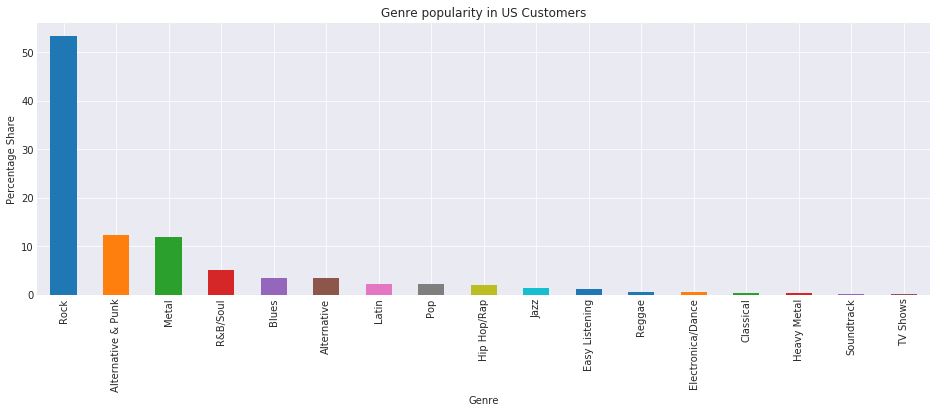

In [28]:
ax = df.plot.bar(x = 'Genre', y = 'Percentage Share %', figsize = (16,5), legend = False, 
                title = "Genre popularity in US Customers")
sns.set_style('darkgrid')
ax.set_ylabel('Percentage Share')
plt.show()

We can see that for Chinook, both pop and Hip Hop/Rap have the lowest market share in the US at 2.09% and 1.90%, respectively. Chinook should probably advertise 'Red Tone' (Punk) and 'Slim Jim Bites' (Blues). 'Meteor and the Girls' and 'Regal' both produce music in unpopular genres in the US. However, as pop has a slightly higher market share, based on this criteria alone Chinook should advertise 'Meteor and the Girls'. It may be wise in this case to also take into consideration other characteristics however.

### Which employees are performing the best? (Bringing the most revenue)

In [29]:
query = '''
SELECT
    e.first_name||' '||e.last_name "Employee Name",
    e.title Position,
    e.hire_date "Hire Date",
    SUM(COALESCE(i.total,0)) "Total Sales"
FROM employee e
LEFT JOIN customer c ON c.support_rep_id = e.employee_id
LEFT JOIN invoice i ON i.customer_id = c.customer_id
GROUP BY "Employee Name"
ORDER BY "Total Sales" DESC, "Employee Name"
'''

df = run_query(query)
df

,Employee Name,Position,Hire Date,Total Sales
0,Jane Peacock,Sales Support Agent,2017-04-01 00:00:00,1731.51
1,Margaret Park,Sales Support Agent,2017-05-03 00:00:00,1584.00
2,Steve Johnson,Sales Support Agent,2017-10-17 00:00:00,1393.92
3,Andrew Adams,General Manager,2016-08-14 00:00:00,0.00
4,Laura Callahan,IT Staff,2017-03-04 00:00:00,0.00
5,Michael Mitchell,IT Manager,2016-10-17 00:00:00,0.00
6,Nancy Edwards,Sales Manager,2016-05-01 00:00:00,0.00
7,Robert King,IT Staff,2017-01-02 00:00:00,0.00


Text(0,0.5,'')

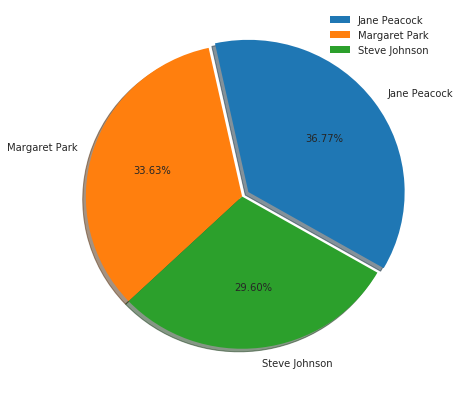

In [42]:
ax = df[:3].plot(kind = 'pie', y = 'Total Sales', labels = df['Employee Name'], figsize = (7,7),
                autopct='%1.2f%%',startangle = -30, explode = (0.05,0,0), shadow = True)
ax.set_ylabel('')

Looks like Jane Peacock is the best performer, followed by Margaret Park and Steve Johnson. They all work as sales support agents. We have values of 0 for the other employees because they are either not employed in a sales role, or hold a managerial position.

It's also possible that Jane has more total sales than Margaret, and Margaret has more total sales than Steve because they were hired in that order.